In [ ]:
"""
4/26/2023

Dataset used: 139,502 "placed" and 139,502 "Not Placed"
                        train set: 67% (187,032)     test set: 33% (92,072)
                        
xgBoostRegressor and new weights with metrics MSE, RMSE, and MAE
     New weights using
     - feature importance
     - Shapley
     - permutation
     
     New features not used in current Z-engine:
     - YearsOfExperienceScore
     - SkillClusterToClusterScore
     - RelavantMonthsOfExperience
     - FeeEligibilityScore

Comparison with current Z-engine: weighted sum on the same test datset
"""

In [ ]:
 #pip install smart-open
# to import datasets from s3

In [ ]:
# conda install -c conda-forge xgboost              # xgBoost library

Solving environment: \ 

In [3]:
#pip install shap                    # Shapley library

  Using cached shap-0.41.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (569 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 20.1
    Uninstalling packaging-20.1:
      Successfully uninstalled packaging-20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
sagemaker 2.145.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.3.0 which is incompatible.
sagemaker 2.145.0 requires PyYAML==5.4.1, but you have pyyaml 6.0 which is incompatible.
docker-compose 1.29.2 requires PyYAML<6,>=3.10, but you have pyyaml 6.0 which is incompatible.

[

In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

# xgBoostRegressor model
from xgboost import XGBRegressor

# additional weight extraction methods in additiona to built-in Feature Importance
import shap
from sklearn.inspection import permutation_importance

# Regression metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [8]:
import smart_open

# access dataset in s3
with smart_open.open('s3://vector-services-ied-np/z-engine-weight-training/balanced_set.csv', 'r') as data_handler:
    data = pd.read_csv(data_handler)

In [5]:
# placed flag used for Placed (1.0) or Not Placed (0.0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279004 entries, 0 to 279003
Data columns (total 23 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Unnamed: 0                               279004 non-null  int64  
 1   LocatorKey                               279004 non-null  object 
 2   SalesforceID                             270167 non-null  object 
 3   JobPostingID                             279004 non-null  object 
 4   AverageWorkHistoryScore                  279004 non-null  float64
 5   ComutabilityScore                        279004 non-null  float64
 6   DescriptionClusterToClusterScore         279004 non-null  float64
 7   EliteSkillScore                          279004 non-null  float64
 8   FeeEligibilityScore                      279004 non-null  float64
 9   FilteredRawScore                         279004 non-null  float64
 10  JobSkillsScore                  

In [9]:
# Select only the feature columns to use for xgBoostRegressor training

columns = [ 'AverageWorkHistoryScore',
 'ComutabilityScore',
 'DescriptionClusterToClusterScore',
 'EliteSkillScore',
 'FeeEligibilityScore',
 'JobSkillsScore',
 'JobSoftwareSkillsScore',
 'LatestWorkHistoryDescriptionVectorScore',
 'LatestWorkHistoryTitleVectorScore',
 'NrmlzdDescClusterScore',
 'NrmlzdSkillClusterScore',
 'NrmlzdTitleClusterScore',
 'RelevantMonthsOfExperience',
 'SkillClusterToClusterScore',
 'TitleClusterToClusterScore',
 'YearsOfExperienceScore']
features = data[columns]

# target variables: 1.0 Placed and 0.0 Not placed
target = data[['placed flag']]

In [10]:
# Split data into training and test sets

X=features
y=np.ravel(target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

In [11]:
# Scale entry values to avoide skewing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)     # standard scaler is used on the train dataset
X_train = scaler.transform(X_train)        # scale the train dataset
X_test = scaler.transform(X_test)           # scale the test dataset

In [10]:
# Train the model using standard hyper parameters. The hyper parameters are shown

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<BarContainer object of 16 artists>

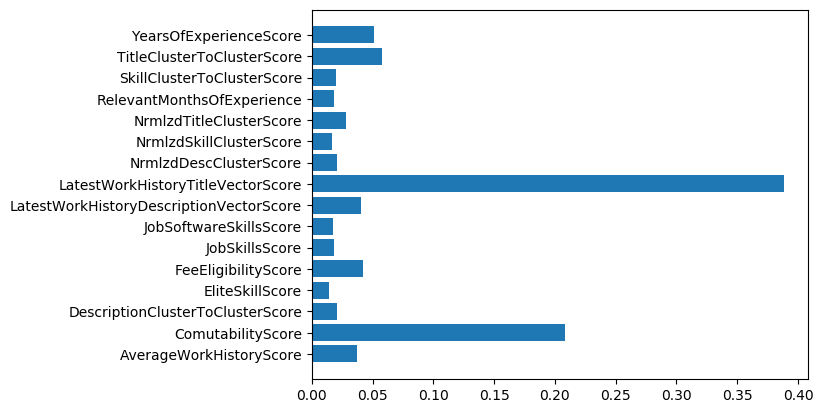

In [11]:
# Bar chart of the features based on Feature Importance from the xgBoostRegressor model

weights_xgb = xgb.feature_importances_          # weight vector
feature_names = list(features.columns)
plt.barh(list(features.columns), weights_xgb)

In [12]:
# Function to compute the MSE, RMSE, and MAE of the predicted values

def metrics(y_test, y_pred):
    mse = MSE(y_test, y_pred)
    rmse = np.sqrt(MSE(y_test, y_pred))
    mae = MAE(y_test, y_pred)
    print("MSE: % f" %(mse))
    print("RMSE : % f" %(rmse))
    print("MAE : % f" %(mae))

In [13]:
# Get inference values from the trained model on the test dataset.
y_pred = xgb.predict(X_test)
print("xgBoostRegressor inference: ", y_pred)
print("")

# Compute MSE, RMSE, and MAE of the xgBoostRegressor model on the test dataset.
print("with xgBoost Regressor")
print("")
metrics(y_test, y_pred)

xgBoostRegressor inference:  [0.21284905 0.26337558 0.5423697  ... 0.13744926 0.8235928  0.3683502 ]

with xgBoost Regressor

MSE:  0.178839
RMSE :  0.422893
MAE :  0.358257


In [14]:
# Get weighted sum on the test dataset using the newly found Feature Importance weights
print(weights_xgb)
new_z_scores = np.matmul(X_test, weights_xgb)
print("New Z-scores with Feature Importance weights: ", new_z_scores)

[0.0374823  0.20832127 0.02038596 0.01418077 0.0418445  0.01831206
 0.01703496 0.04080858 0.3887036  0.02086849 0.01679379 0.02835643
 0.01805015 0.02007581 0.05758946 0.05119184]
New Z-scores with Feature Importance weights:  [-0.70676198 -0.48785006 -0.09900133 ... -1.03830968  0.79895559
  0.0572345 ]


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Function to scale weighted sums using standard and minmax 
def scale(z_scores):
    z_scores = z_scores.reshape(-1, 1)
    scaler_standard = StandardScaler().fit(z_scores)
    z_scores_standard = scaler_standard.transform(z_scores)
    scaler_minmax = MinMaxScaler().fit(z_scores)
    z_scores_minmax = scaler_minmax.transform(z_scores)
    
    return z_scores_standard, z_scores_minmax

In [23]:
feature_standard, feature_minmax = scale(new_z_scores)
print("with new weights from xgBoostRegressor Feature Importance")

print("Feature Importance standard scaler")
metrics(y_test, feature_standard)

print("Feature Importance minmax scaler")
metrics(y_test, feature_minmax)

with new weights from xgBoostRegressor Feature Importance
Feature Importance stadard scaler
MSE:  1.071327
RMSE :  1.035049
MAE :  0.824375
Feature Importance minmax scaler
MSE:  0.218211
RMSE :  0.467130
MAE :  0.441460


In [24]:
# Permutation Importance
perm_importance = permutation_importance(xgb, X_test, y_test)
print("Permutation importance: ", perm_importance)
perm_weights = perm_importance['importances_mean']
print("Permutation importance weights: ", perm_weights)

Permutation importance:  {'importances_mean': array([0.19811828, 0.03409492, 0.02373024, 0.00078385, 0.02529603,
       0.01105802, 0.00334853, 0.09924934, 0.17038937, 0.01815744,
       0.00879154, 0.01291632, 0.01122409, 0.01070256, 0.01190106,
       0.0247534 ]), 'importances_std': array([3.14711434e-03, 4.59857103e-04, 6.14740643e-04, 5.75746321e-05,
       9.36162652e-04, 3.96828380e-04, 1.55804489e-04, 8.37457488e-04,
       1.05937312e-03, 5.52730378e-04, 3.14891322e-04, 2.29312237e-04,
       2.60538399e-04, 5.23475706e-04, 4.56183620e-04, 5.31623482e-04]), 'importances': array([[0.20095152, 0.19268729, 0.19658821, 0.1994278 , 0.20093658],
       [0.0338441 , 0.03489315, 0.03428986, 0.03387164, 0.03357587],
       [0.02350482, 0.02274274, 0.02364919, 0.0242777 , 0.02447675],
       [0.0008385 , 0.00078321, 0.0008409 , 0.00068268, 0.00077394],
       [0.02482513, 0.02366549, 0.02609461, 0.02603452, 0.02586038],
       [0.01104569, 0.01103891, 0.01093399, 0.01051957, 0.01175194]

In [25]:
perm_z_scores = np.matmul(X_test,perm_weights)

perm_standard, perm_minmax = scale(perm_z_scores)

print("with new weights from xgBoostRegressor Permutation Importance")

print("Permutation Importance standard scaler")
metrics(y_test, perm_standard)

print("Permutation Importance minmax scaler")
metrics(y_test, perm_minmax)

with new weights from xgBoostRegressor Permutation Importance
Permutation Importance stadard scaler
MSE:  1.173867
RMSE :  1.083451
MAE :  0.822908
Permutation Importance minmax scaler
MSE:  0.287623
RMSE :  0.536305
MAE :  0.469152


In [28]:
# Shapley
# Shapley values: number of samples x number of features
# We want the mean Shapley value of each feature

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap_mean = np.abs(shap_values).mean(axis=0)
shap_mean

array([0.07097949, 0.03314528, 0.02481066, 0.00250578, 0.02318066,
       0.02056466, 0.00938576, 0.04774192, 0.11589911, 0.01437673,
       0.01113185, 0.01916555, 0.01507601, 0.017559  , 0.02728132,
       0.01960758], dtype=float32)

In [30]:
shap_z_scores = np.matmul(X_test, shap_mean)
shap_standard, shap_minmax = scale(shap_z_scores)

print("with new Shapley weights from xgBoost Regressor")
print("Shapley Importance standard scaler")
metrics(y_test, shap_standard)

print("Shapley Importance minmax scaler")
metrics(y_test, shap_minmax)

with new Shapley weights from xgBoost Regressor
Shapley Importance stadard scaler
MSE:  1.134893
RMSE :  1.065314
MAE :  0.817313
Shapley Importance stadard scaler
MSE:  0.266844
RMSE :  0.516570
MAE :  0.462009


In [38]:
# We want to compare with the current z_score metrics

# Select only the features that are used in current Z-engine.

cols = [ 'NrmlzdTitleClusterScore',
         'NrmlzdDescClusterScore',
         'NrmlzdSkillClusterScore',
         'LatestWorkHistoryDescriptionVectorScore',
         'LatestWorkHistoryTitleVectorScore',
         'AverageWorkHistoryScore',
        'JobSkillsScore',
        'JobSoftwareSkillsScore',
        'ComutabilityScore',
        'YearsOfExperienceScore',
        'DescriptionClusterToClusterScore',
         'TitleClusterToClusterScore',
        'EliteSkillScore',
        'FilteredRawScore'
]

current_z  = data[cols]
current_z

,NrmlzdTitleClusterScore,NrmlzdDescClusterScore,NrmlzdSkillClusterScore,LatestWorkHistoryDescriptionVectorScore,LatestWorkHistoryTitleVectorScore,AverageWorkHistoryScore,JobSkillsScore,JobSoftwareSkillsScore,ComutabilityScore,YearsOfExperienceScore,DescriptionClusterToClusterScore,TitleClusterToClusterScore,EliteSkillScore,FilteredRawScore
0,0.655994,0.936249,0.954516,0.897801,0.416134,0.860224,0.685821,0.000000,1.0,1.000000,0.905699,0.477965,0.0,8.694937
1,0.866131,0.965632,0.895718,0.899660,0.814271,0.899660,0.557483,0.000000,0.0,1.000000,0.950384,0.770299,0.0,9.345664
2,0.943498,0.929602,0.982845,0.816494,0.542276,0.604478,0.732026,0.544263,0.0,0.670886,0.901425,0.602923,0.0,9.126186
3,0.793568,0.901341,0.815631,0.767869,0.792423,0.786914,0.863127,0.000000,0.0,1.000000,0.874471,1.000000,0.0,9.438727
4,0.998848,0.644051,0.890473,0.499489,1.000000,0.485634,0.586147,0.000000,1.0,0.000000,0.909619,1.000000,0.5,7.840209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278999,0.950208,0.794546,0.879721,0.587496,0.829518,0.587496,0.888116,0.000000,0.0,0.000000,0.787772,0.896770,0.0,8.038698
279000,0.630197,0.908230,0.872790,0.811066,0.605813,0.859738,0.619005,0.378318,0.0,1.000000,0.971502,0.523341,0.0,8.928976
279001,0.998996,0.917722,0.832165,0.900493,0.566587,0.838159,0.817954,0.000000,1.0,1.000000,0.957657,0.592976,0.0,9.360389
279002,0.929638,0.957528,0.969031,0.935558,0.946966,0.890787,0.824960,0.000000,0.0,1.000000,0.992683,0.902927,0.0,10.291831


In [33]:
# Split the dataset into train and test using the same random number generator as in xgBoostRegressor
# Scole

X = current_z
X_train_current, X_test_current, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

#scaler = StandardScaler().fit(X_train_current)
#X_test_current = scaler.transform(X_test_current) 

In [39]:
# Extract current Z-scores
weights = [0.682, 0.684, 0.684, 1.0, 0.726, 0.797, 0.532, 0.891, 0.558, 0.090, 0.759, 0.774, 1.608, 0.79]
current_z_scores = np.matmul(X_test_current, weights)

In [3]:
def min_max(num):
    print("min: ", min(num))
    print("max: ", max(num))
    
min_max(current_z_scores)

In [ ]:
current_standard, current_minmax = scale(current_z_scores)

print("with new Shapley weights from xgBoost Regressor")
print("Current Z-scores standard scaler")
metrics(y_test, current_standard)

print("Current Z-scores minmax scaler")
metrics(y_test, current_minmax)

In [19]:
# from weight_extraction.ipynb
# DecisionTreeClassifier and RandomForestClassifier return the same feature importance weights.

dt_weights = [0.08553848, 0.02941326, 0.0647263, 0.00518431, 0.034758, 0.07174241,
 0.02928398, 0.09578101, 0.18128402, 0.08011271, 0.06946803, 0.07658214,
 0.05479345, 0.06338066, 0.04512305, 0.01282818]
dt_z_scores = np.matmul(X_test, dt_weights)

dt_standard, dt_minmax = scale(dt_z_scores)

print("with new weights from DecisionTreeClassifier")
print("Decision tree weight standard scaler")
metrics(y_test, dt_standard)

print("Decision tree weight minmax scaler")
metrics(y_test, dt_minmax)

with new weights from DecisionTreeClassifier
Decision tree weight standard scaler
MSE:  1.172950
RMSE :  1.083028
MAE :  0.811601
Decision tree weight minmax scaler
MSE:  0.266538
RMSE :  0.516273
MAE :  0.469945
